###  EDA
#### 1.1 labels 
- Multilabel classfication problem. For example, one photo contains both 'argriculture', 'partly_cloudy','water'tags
- Highly imbalanced (Most tags contains primary, while most tags appeared less than .05% of the photos)

Set tensorflow environment
```python
source activate tensorflow_p36
```

Cloudy should have no other labels, but there may be labeling errors

In [26]:
from keras.preprocessing.text import Tokenizer
from pylab import uint8 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from collections import OrderedDict

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
labels = pd.read_csv(kaggle_path+'train_v2.csv')

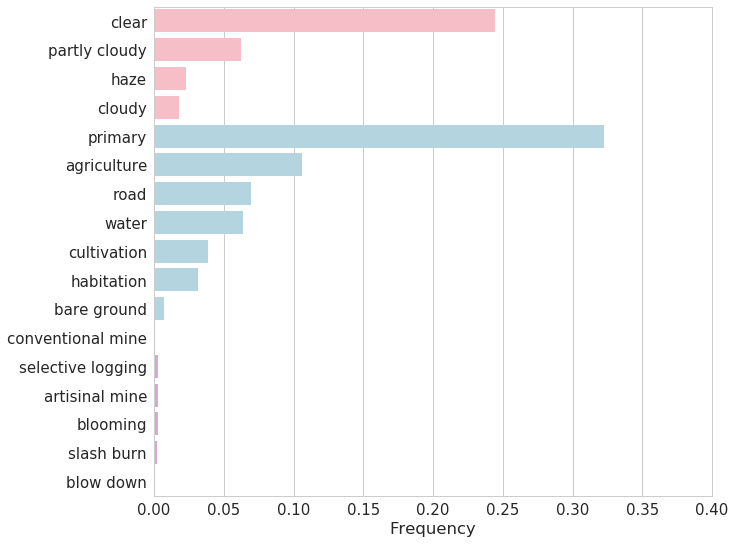

In [27]:
def plot_tag_distribution():
    texts = labels.tags.tolist()
    tokenizer = Tokenizer(filters='"(),./:~')
    tokenizer.fit_on_texts(texts)
    tags = tokenizer.word_docs
    myorder = [ 'clear', 'partly_cloudy','haze', 'cloudy',  
                'primary', 'agriculture', 'road', 'water','cultivation', 'habitation','bare_ground', 
            'conventional_mine', 'selective_logging', 'artisinal_mine', 'blooming','slash_burn', 'blow_down' ]
    tags = OrderedDict((k, tags[k]) for k in myorder)
    y = [i.replace('_',' ') for i in tags.keys()]
    sns.set(style="whitegrid",font_scale=1.5)
    f, ax = plt.subplots(figsize=(10, 9))
    sns.set_color_codes("pastel")
    colour = ['lightblue']*17
    colour[0:5] = ['lightpink']*4
    colour[11:] = ['plum']*6
    freq = np.array(list(tags.values()))/sum(list(tags.values()))
    sns.barplot(x=freq,
                y=y, 
                color="b",
                orient = "h",
                palette=colour
               )
    ax.set(xlim=(0, .4), ylabel="",
           xlabel="Frequency")    

    return tags
tags = plot_tag_distribution()

In [28]:
print ('haze vs clear ',tags['primary'],' : ',tags['agriculture'])
tags.keys()

haze vs clear  37513  :  12315


odict_keys(['clear', 'partly_cloudy', 'haze', 'cloudy', 'primary', 'agriculture', 'road', 'water', 'cultivation', 'habitation', 'bare_ground', 'conventional_mine', 'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down'])

#### Examples of photos
Display 20 photos at random choice

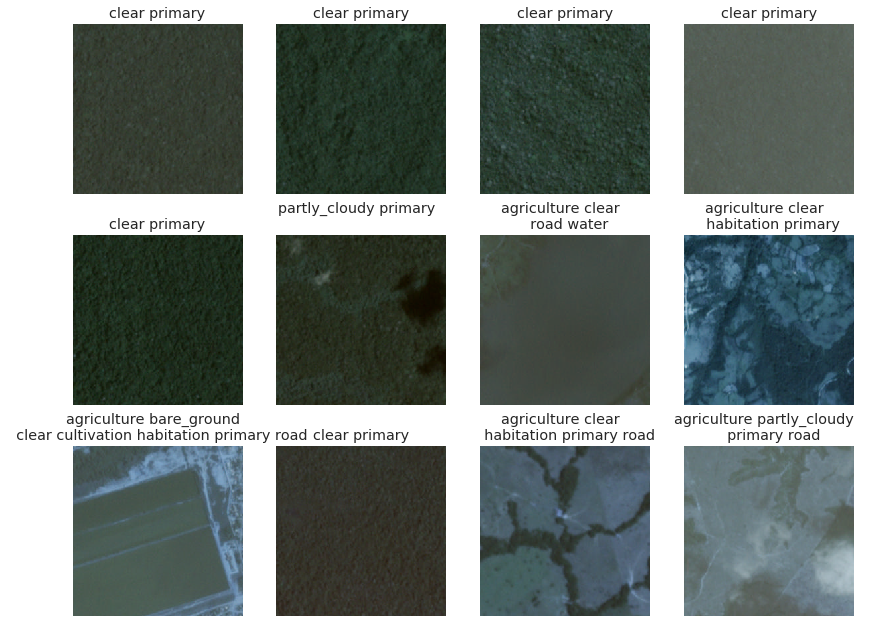

In [96]:
def display_photos(rows,columns):
    sns.set(style="whitegrid",font_scale=1.2)

    fig = plt.figure(figsize=(14, 11))
    for i in range(1, columns*rows +1):
        img_id = np.random.randint(40000)
        path = kaggle_path+f'train-jpg/train_{img_id}.jpg'
        img  = cv2.imread(path)
        ax = fig.add_subplot(rows, columns, i)
        ax.set_axis_off()
        
        title = labels.tags[img_id]
        if len(title) > 20:
            title = ' '.join(title.split(' ')[0:2] +[' \n ']+ title.split(' ')[2::])
        ax.set_title(title)
        plt.imshow(img)
    plt.show()
        
display_photos(rows=3,columns=4)

###  Dehaze image
#### 1. Calculate haze degree
Source: [Detecting Foggy Images and Estimating the Haze Degree Factor](https://www.omicsonline.org/open-access/detecting-foggy-images-and-estimating-the-haze-degree-factor-jcsb.1000226.pdf)

Define haze degree as w, where w is a number between (0,1). Smaller w indicates a clearer image while haze images have greater w.  For example, w greater than 0.7 means 80%-100% of the image area is hazed.

#### 2. Dehaze images
Source: [Single Image Haze Removal Using Dark Channel Prior](http://kaiminghe.com/publications/pami10dehaze.pdf)

The following formula is widely used to describe the formation of a haze image

$I(x) = J(x)t(x) + A(1-t(x))$

where *I* is the observed intensity, *J* represents the original haze-free image to be recovered, *A* is the global atmospheric light, and *t* is an exponential decay distribution .

The aim is to recover *J* from *I*. We can achieve that by tuning *t*, as *t* has a formula of

$t(x) = 1- w\times min[min(\frac{I_{c}(y)}{A^{c}})]$
,where *w* is weight coefficient, *c* is the dark channel color (darkest channel of RGB channel)

In [105]:
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray,img_width=256):
    """return Atomospheric light A 
       find brightest pixels in the dark channel and find max intensity
    """
    toplist = [Channel_value()] * 2
    dark_channel = find_dark_channel(img)
    coords = np.argwhere(img[:,:,dark_channel] == np.max(img[:,:,dark_channel]) )
    I = [gray[c[0],c[1]] for c in coords]
    return max(I)

def find_dark_channel(img): #get darkest RBG channel
    return np.unravel_index(np.argmin(img), img.shape)[2]

def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def dehaze_function(img, light_intensity, windowSize, t0, w,img_width=256):
    outimg = np.zeros(img.shape, img.dtype)
    # sliding windowns
    # try tf.train.batch
    for y in range(img_width):
        for x in range(img_width):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), img_width)
            y_high = min(y+(windowSize//2), img_width)
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg



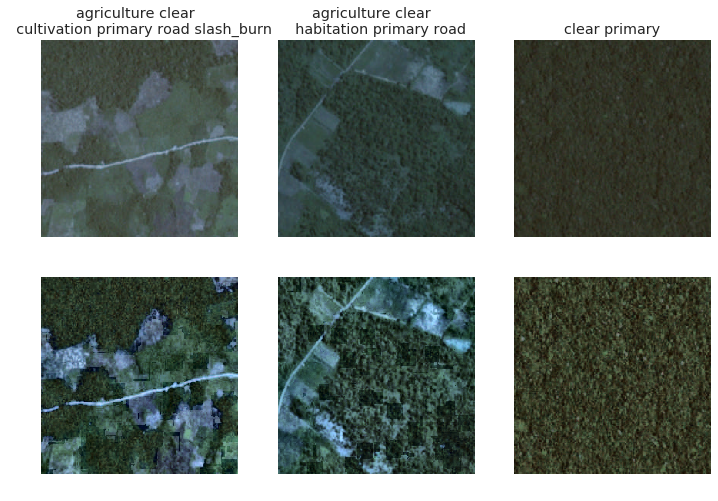

In [231]:

def compare(row=2,col=3):
    fig = plt.figure(figsize=(col*4, row*4))
    
    for i in range(1,col+1,1):
        img_id = np.random.randint(40000)
#         img_id = 40077
        path = kaggle_path+f'train-jpg/train_{img_id}.jpg'
        img  = cv2.imread(path)
        ax = fig.add_subplot(row, col, i)
        ax.set_axis_off()
        plt.imshow(img)
        title = labels.tags[img_id]
        if len(title) > 20:
            title = ' '.join(title.split(' ')[0:2] +[' \n ']+ title.split(' ')[2::])
        ax.set_title(title)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
        light_intensity = find_intensity_of_atmospheric_light(img, gray)
        haze_free = dehaze_function(img, light_intensity, 20, t0=0.54, w=0.8)
       
        ax1 = fig.add_subplot(row, col, i+col*1)
        clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
        lab = cv2.cvtColor(haze_free, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
        l, a, b = cv2.split(lab)  # split on 3 different channels
        l2 = clahe.apply(l)  # apply CLAHE to the L-channel
        lab = cv2.merge((l2,a,b))  # merge channels
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  
        plt.imshow(img)
        ax1.set_axis_off()
    plt.show()
compare()